<a href="https://colab.research.google.com/github/zbiswas3/Machine_learning_gatech/blob/master/posture_data_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, learning_curve, validation_curve, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.impute import  SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sns.set(rc={'figure.figsize':(12,8.5)})
sns.set_context('poster', font_scale=0.75)

#INTRODUCTION

## **Utils**

In [ ]:
# validatiion curve
def valid_plot(
    X, 
    y, 
    param_range, 
    param_name, 
    estimator, 
    xlabel="parameter", 
    ylabel="accuracy score",  
    title="Validation Curve"
    ):
  train_scores, test_scores = validation_curve(
      estimator,
      X,
      y,
      param_name=param_name,
      param_range=param_range,
      scoring="accuracy",
      n_jobs=2,
      cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=42)
  )
  train_scores_mean = np.mean(train_scores, axis=1)
  train_scores_std = np.std(train_scores, axis=1)
  test_scores_mean = np.mean(test_scores, axis=1)
  test_scores_std = np.std(test_scores, axis=1)

  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  # plt.ylim(0.0, 1.1)
  lw = 2
  plt.plot(
      param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
  )
  plt.fill_between(
      param_range,
      train_scores_mean - train_scores_std,
      train_scores_mean + train_scores_std,
      alpha=0.2,
      color="darkorange",
      lw=lw,
  )
  plt.plot(
      param_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
  )
  plt.fill_between(
      param_range,
      test_scores_mean - test_scores_std,
      test_scores_mean + test_scores_std,
      alpha=0.2,
      color="navy",
      lw=lw,
  )
  plt.legend(loc="best")
  return plt


In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy',
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(26, 8))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring=scoring,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


In [ ]:
# Calculate bias and variance of the model
def bias_var(y_test, y_pred):
    mean_predictions = np.mean(y_pred, axis=0)
    avg_bias = np.sum((mean_predictions - y_test)**2) / y_test.size
    avg_var = np.sum((mean_predictions - y_pred)**2) / y_pred.size

    return avg_var, avg_bias


## data 

In [ ]:
%%capture
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00405/Postures.zip"
!unzip 'Postures.zip'

In [ ]:
data = pd.read_csv('Postures.csv')
for val in list(data.columns.values):
    data[val] = pd.to_numeric(data[val], errors='coerce')
    
data=data.sample(frac=0.45, random_state=42)
data.shape


(35143, 38)

## Data analysis

In [ ]:
sim = SimpleImputer()

In [ ]:
data = pd.DataFrame(sim.fit_transform(data), columns=data.columns)


In [ ]:
data = data[data.Class >0]
data['Class'] = data['Class'].astype('int')
data.Class.unique()

array([3, 4, 2, 5, 1])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35142 entries, 0 to 35142
Data columns (total 38 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Class   35142 non-null  int64  
 1   User    35142 non-null  float64
 2   X0      35142 non-null  float64
 3   Y0      35142 non-null  float64
 4   Z0      35142 non-null  float64
 5   X1      35142 non-null  float64
 6   Y1      35142 non-null  float64
 7   Z1      35142 non-null  float64
 8   X2      35142 non-null  float64
 9   Y2      35142 non-null  float64
 10  Z2      35142 non-null  float64
 11  X3      35142 non-null  float64
 12  Y3      35142 non-null  float64
 13  Z3      35142 non-null  float64
 14  X4      35142 non-null  float64
 15  Y4      35142 non-null  float64
 16  Z4      35142 non-null  float64
 17  X5      35142 non-null  float64
 18  Y5      35142 non-null  float64
 19  Z5      35142 non-null  float64
 20  X6      35142 non-null  float64
 21  Y6      35142 non-null  float64
 22

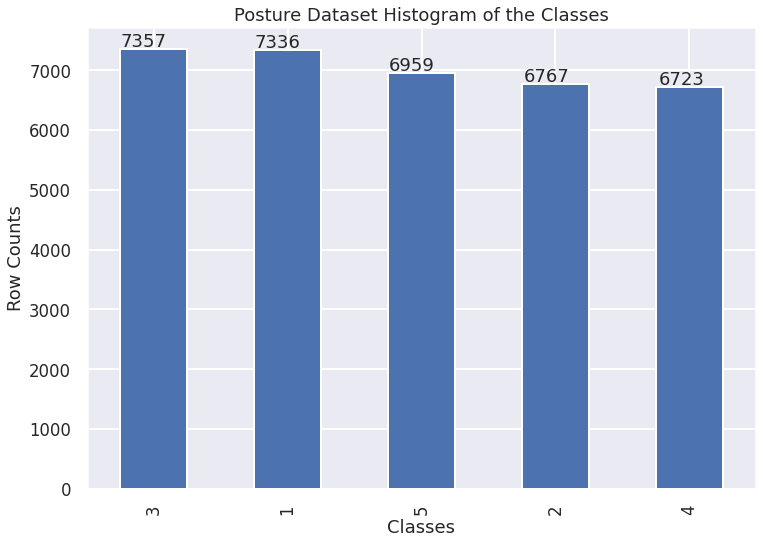

In [ ]:
ax = data.Class.value_counts().plot(kind='bar')
try:
  ax.bar_label(ax.containers[0])
except:
  for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

plt.title("Posture Dataset Histogram of the Classes")
plt.xlabel("Classes")
plt.ylabel("Row Counts")
plt.show()

## Data preprocessing

In [ ]:
cat_columns = data.select_dtypes('object').columns.tolist()
for col in cat_columns:
  data[col] = data[col].astype('category').cat.codes
data.head()

,Class,User,X0,Y0,Z0,X1,Y1,Z1,X2,Y2,Z2,X3,Y3,Z3,X4,Y4,Z4,X5,Y5,Z5,X6,Y6,Z6,X7,Y7,Z7,X8,Y8,Z8,X9,Y9,Z9,X10,Y10,Z10,X11,Y11,Z11
0,3,6.0,109.240478,44.899381,-60.024315,61.033350,85.559458,-18.295491,68.721592,0.169402,-66.863960,11.542282,84.467412,-33.672673,52.229240,136.226905,-13.461600,92.907674,26.103671,-62.525220,-9.119754,82.657635,-32.104225,44.219670,88.622517,-20.210009,48.058413,86.021193,-24.230812,54.593085,80.971477,-27.625913,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597
1,4,11.0,24.330178,101.140373,1.816550,55.473059,131.027370,13.658764,16.883000,148.501225,6.423454,114.212940,38.602086,-61.127214,72.265570,12.157565,-56.796850,92.830339,28.800005,-60.120643,52.767190,93.407573,-0.229293,44.219670,88.622517,-20.210009,48.058413,86.021193,-24.230812,54.593085,80.971477,-27.625913,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597
2,4,13.0,63.498073,17.176245,-60.413507,74.682024,48.333237,-57.479898,32.838805,147.810305,-12.697328,50.741438,137.808138,-16.903903,71.460231,75.724995,-57.773480,32.572369,99.871957,-8.085566,53.522974,97.148466,-11.820767,44.219670,88.622517,-20.210009,48.058413,86.021193,-24.230812,54.593085,80.971477,-27.625913,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597
3,2,14.0,86.767860,74.450010,-46.187383,57.077763,99.699882,-13.512337,52.828546,151.329974,12.972557,59.619855,36.147365,-56.078468,66.259513,144.173187,-6.390248,16.861316,143.212475,34.183860,13.494791,94.610410,12.191463,-2.985673,123.914195,27.534306,71.138877,56.656104,-49.460886,-9.180367,80.449669,13.646088,38.404759,106.030959,0.419250,-41.541234,24.841743,9.02597
4,5,14.0,-2.025544,99.352134,6.365841,76.213345,33.631282,-41.670484,87.056709,61.502402,-59.262181,-29.853791,77.790630,-17.576383,26.685505,136.893558,-31.884217,55.130637,129.133685,-43.232234,61.867149,101.286413,-6.095230,-2.516153,125.257435,-42.207798,28.077631,108.108797,11.555042,-21.859351,103.919267,-55.090304,53.191971,74.279928,-28.846752,-41.541234,24.841743,9.02597


## Data split

In [ ]:
X, X_test, y, y_test = train_test_split(data[data.columns[2:]], data[data.columns[0]].values, test_size=0.33, random_state=42)

In [ ]:
scale = StandardScaler()
scale.fit(data.iloc[:, 2:].values)

X = scale.transform(X.values)
X_test = scale.transform(X_test.values)

X.shape

(23545, 36)

# SVM Classification


## Gridsearch cross validation

In [ ]:
%%time
model = SVC()
# define the grid of values to search
grid = dict()
grid['kernel'] = ['poly']
grid['degree'] = [1, 2, 3]
# grid['gamma'] = ['scale', 'auto']

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', verbose=10)

# execute the grid search
grid_result = grid_search.fit(X, y)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.943640 using {'degree': 2, 'kernel': 'poly'}
0.802039 (0.004301) with: {'degree': 1, 'kernel': 'poly'}
0.943640 (0.002118) with: {'degree': 2, 'kernel': 'poly'}
0.909365 (0.001000) with: {'degree': 3, 'kernel': 'poly'}
CPU times: user 12.6 s, sys: 321 ms, total: 12.9 s
Wall time: 3min


In [ ]:
%%timeit
model = SVC()
# define the grid of values to search
grid = dict()
grid['kernel'] = ['rbf',]
# grid['degree'] = [2, 3]
grid['gamma'] = [0.01, 0.025, 0.05, 0.075, 0.1, 'auto', 'scale']

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy', verbose=10)

# execute the grid search
grid_result = grid_search.fit(X, y)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best: 0.970609 using {'gamma': 0.05, 'kernel': 'rbf'}
0.940115 (0.001928) with: {'gamma': 0.01, 'kernel': 'rbf'}
0.966617 (0.003090) with: {'gamma': 0.025, 'kernel': 'rbf'}
0.970609 (0.001893) with: {'gamma': 0.05, 'kernel': 'rbf'}
0.968741 (0.001829) with: {'gamma': 0.075, 'kernel': 'rbf'}
0.965003 (0.001597) with: {'gamma': 0.1, 'kernel': 'rbf'}
0.968698 (0.002819) with: {'gamma': 'auto', 'kernel': 'rbf'}
0.968274 (0.002929) with: {'gamma': 'scale', 'kernel': 'rbf'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best: 0.970609 using {'gamma': 0.05, 'kernel': 'rbf'}
0.940115 (0.001928) with: {'gamma': 0.01, 'kernel': 'rbf'}
0.966617 (0.003090) with: {'gamma': 0.025, 'kernel': 'rbf'}
0.970609 (0.001893) with: {'gamma': 0.05, 'kernel': 'rbf'}
0.968741 (0.001829) with: {'gamma': 0.075, 'kernel': 'rbf'}
0.965003 (0.001597) with: {'gamma': 0.1, 'kernel': 'rbf'}
0.968698 (0.002819) with: {'gamma': 'auto', 'kernel': 'rb

## Final estimator design

In [ ]:
estimator = SVC()

## Validation Curve

TypeError: ignored

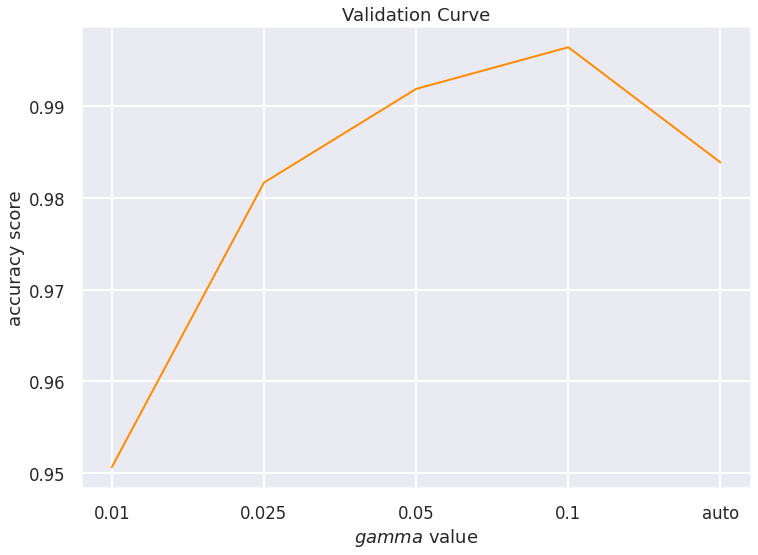

In [ ]:
%%time
valid_plot(    
    X, 
    y, 
    param_range=[0.01, 0.025, 0.05, 0.1, 'auto'], 
    param_name='gamma', 
    estimator=estimator,
    xlabel=r"$gamma$ value",
    )
plt.show()

In [ ]:
estimator = SVC(kernel="poly")

In [ ]:
%%time
valid_plot(    
    X, 
    y, 
    param_range=[1,2,3], 
    param_name='gamma', 
    estimator=estimator,
    xlabel=r"$gamma$ value",
    )
plt.show()

## Learning Curves

In [ ]:
estimator = SVC(kernel='rbf', gamma='scale')

In [ ]:
%%time
title = "Learning Curves (SVC)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=5, random_state=42)
#  ShuffleSplit(n_splits=50, test_size=0.25, random_state=0)

plot_learning_curve(
    estimator, title, X, y, cv=cv, n_jobs=4
)

plt.show()

## Prediction and accuracy

In [ ]:
estimator = SVC(kernel='rbf', gamma='scale')

In [ ]:
%%time
estimator.fit(X, y)

CPU times: user 11.8 s, sys: 81.3 ms, total: 11.9 s
Wall time: 11.9 s


SVC()

In [ ]:
%%time
y_pred = estimator.predict(X_test)

CPU times: user 8.23 s, sys: 0 ns, total: 8.23 s
Wall time: 8.21 s


In [ ]:
print("Training Score:", estimator.score(X, y))
print("Testing Score:", estimator.score(X_test, y_test))


Training Score: 0.9841579953280951
Testing Score: 0.972751573682849


## Confusion Matrix

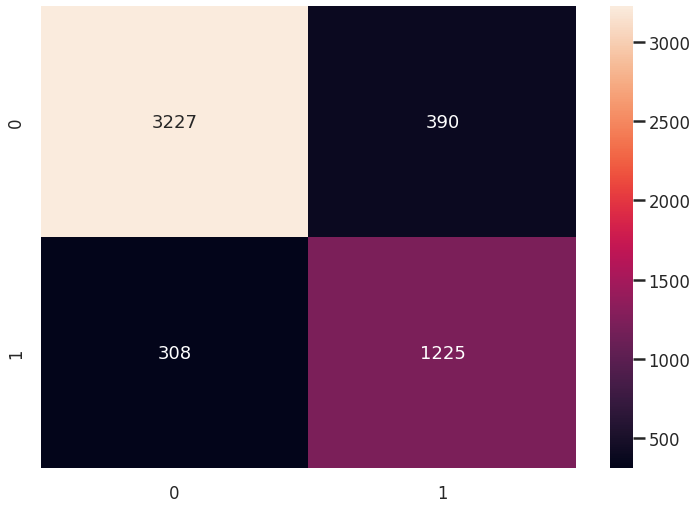

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.show()

## Bias, variance, and error score

In [ ]:
bias_var(y_test, y_pred)

(2.0118092881998746, 2.0157556588291734)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.98      0.99      0.99      2379
           2       0.97      0.96      0.97      2199
           3       0.97      0.98      0.97      2475
           4       0.98      0.97      0.98      2172
           5       0.97      0.96      0.96      2372

    accuracy                           0.97     11597
   macro avg       0.97      0.97      0.97     11597
weighted avg       0.97      0.97      0.97     11597



In [ ]:
mean_squared_error(y_test, y_pred)

0.13553398058252428